# PFAS Landfill Emissions Analysis (Sites L19 and L26)

Tools for simulating, analyzing, and mapping landfill methane (CH₄) and PFAS emissions using synthetic receptor grids, Gaussian dispersion, and geospatial hulls.

## Overview

This repository contains a Jupyter-based workflow for a comprehensive analysis of **Per- and Polyfluoroalkyl Substances (PFAS)** emissions from two landfill sites, referred to as **L19** and **L26**, and evaluates the associated environmental and public health risks. The analysis uses atmospheric dispersion modeling to simulate how PFAS compounds spread through the environment under various meteorological conditions.

The codebase also includes utilities to generate synthetic receptor measurements, compute fluxes and emission rates, apply quartile-based spatial analysis, convert model coordinates to geographic latitude/longitude, and visualize results on interactive web maps.

## Key Components

### 🎯 Objectives

- Estimate PFAS emission rates from landfill sources.
- Model atmospheric dispersion patterns using Gaussian plume theory.
- Assess concentration levels at receptor points within surrounding communities.
- Evaluate public health risks through spatial and temporal analysis.
- Generate interactive visualizations and maps for stakeholder communication.

### 📊 Data Sources

- **Convex hull coordinates** for L19 and L26: Define landfill boundaries and study areas.
- **Weather data**: Wind speed, direction, and atmospheric stability classes.
- **Emission parameters**: PFAS and methane concentrations, background levels.
- **Geographic landmarks**: Schools, hospitals, shopping centers, and other points of interest.

## Methodology

### 🔬 Core Modeling

- **Gaussian Plume Modeling**  
  Calculates pollutant concentrations using meteorological data and standard dispersion formulations.

- **Receptor Grid Generation**  
  Creates synthetic monitoring points across each study area to approximate a dense sensor network.

- **Source–Receptor Analysis**  
  Models emissions from multiple point sources within each landfill and links them to receptor concentrations.

- **Coordinate Transformations**  
  Converts between local Cartesian coordinates (x, y in meters) and geographic coordinates (lat, lon) using site-specific centroids and linearized metric–degree factors.

- **Risk Assessment**  
  Evaluates exposure levels relative to background concentrations, supporting qualitative and semi-quantitative risk characterization.

### 📈 Analysis Features

- Daily concentration mapping under varying weather conditions.
- Wind-aligned coordinate system for accurate dispersion modeling.
- Statistical analysis of concentration distributions (quartiles, spatial patterns).
- Interactive **Folium** maps with overlays for:
  - Convex hulls of L19 and L26.
  - Emission sources and receptor points.
  - Community landmarks and other features of interest.
- Time-series visualization of atmospheric conditions.
- Convex hull boundary validation to ensure receptors lie within the modeled domain.

## Geospatial and Hull Utilities

The repository includes tools to:

- Read convex hull coordinates for **L19** and **L26** from spreadsheet files.
- Export hulls as `numpy` arrays for use in modeling and plotting.
- Overlay hulls on:
  - Matplotlib figures (concentration fields, source locations).
  - Folium web maps for interactive inspection.
- Compare model-derived hulls with externally defined polygons (e.g., from GIS/KML/GeoJSON sources).

## Visualization Outputs

### 🗺️ Maps and Plots

- Concentration contour maps for different meteorological scenarios.
- Interactive web maps (Folium) with:
  - Emission sources.
  - Receptor grids.
  - Landfill hulls (L19 and L26).
  - Community landmarks and distance rings (e.g., 1 km, 2 km, 3 km).
- Receptor grid layouts showing spatial sampling distribution.
- Wind roses and basic atmospheric stability diagnostics.
- Statistical summaries and exposure risk assessments.

## Applications

### 💡 Use Cases

- Environmental impact assessment for landfill operations.
- Public health risk communication and community engagement.
- Regulatory compliance and emission monitoring planning.
- Site management and mitigation strategy development.
- Scientific research on PFAS fate, transport, and co-emitted methane.

## Repository Structure (Indicative)

- `notebooks/`  
  Jupyter notebooks implementing the main PFAS and methane analysis for L19 and L26.

- `data/`  
  Input data files (convex hull tables, weather data, parameter JSON, landmarks).

- `src/`  
  Python modules for:
  - Gaussian dispersion calculations.
  - Synthetic receptor grid generation.
  - Coordinate transformations (`xy_to_latlon`, etc.).
  - JSON export of parameters and results.
  - Mapping utilities with Matplotlib and Folium.

- `README.md`  
  Project overview, methodology, and usage notes.

---

**Note**: This analysis integrates atmospheric science, environmental chemistry, and public health methodologies to provide a comprehensive assessment of PFAS and methane emissions from landfills L19 and L26, and their potential impact on surrounding communities.

## Preamble

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.path import Path  # For point-in-polygon (hull)
from scipy.spatial import ConvexHull
import folium
import json

## Input data

Hull vertices for each landfill.


In [32]:
xls_path = "../data/Convex_Hull_Table.xls"

# Read each sheet separately
wake_df    = pd.read_excel(xls_path, sheet_name="Wake")
hanover_df = pd.read_excel(xls_path, sheet_name="Hanover")

# Extract coordinates as NumPy arrays [lat, lon]
convex_hull_wake    = wake_df[["Latitude", "Longitude"]].to_numpy()
convex_hull_hanover = hanover_df[["Latitude", "Longitude"]].to_numpy()

In [33]:
# Compute the centroid of the convex hull
centroid_w = convex_hull_wake.mean(axis=0)
centroid_h = convex_hull_hanover.mean(axis=0)
print(f"Centroid of Wake's convex hull:")
print(f"Latitude: {centroid_w[0]:.6f},  Longitude: {centroid_w[1]:.6f}")
print(f"\nCentroid of Hanover's convex hull:")
print(f"Latitude: {centroid_h[0]:.6f},  Longitude: {centroid_h[1]:.6f}")


Centroid of Wake's convex hull:
Latitude: 35.676091,  Longitude: -78.847150

Centroid of Hanover's convex hull:
Latitude: 34.325666,  Longitude: -77.988866


### Grid vertices
we use a 5km squared grid

In [34]:
x_lim = 5000
y_lim = 5000
hull_vertices= np.array([[0,0],[0,y_lim],[x_lim,y_lim],[x_lim,0]]) # This hull correspond to the grid limits

### __Params__

In [35]:
# Read and extract data for first day in Landfill 19
with open("meteorological_summary.json", "r") as f:
    data_json = json.load(f)

# Filter for Landfill 19 and 26 records
landfill_19_records = [record for record in data_json['summary']['by_site_and_date'] 
                       if record['Site'] == 'Landfill 19']
landfill_26_records = [record for record in data_json['summary']['by_site_and_date'] 
                       if record['Site'] == 'Landfill 26']
# Get the first date record
first_day_L26 = landfill_26_records[0] if landfill_26_records else None

print("First Day Data for Landfill 26:")
print(json.dumps(first_day_L26, indent=4))

First Day Data for Landfill 26:
{
    "Site": "Landfill 26",
    "Date": "2021-11-03",
    "Dir (deg)": 50.0,
    "Avg Speed (m/s)": 3.18,
    "Avg Temp (C)": 8.8,
    "Stability": "C"
}


In [ ]:
# --- Load JSON ---
with open("meteorological_summary.json", "r") as f:
    data_json = json.load(f)

# --- Filter for Landfill 26 ---
landfill_26_records = [
    record for record in data_json["summary"]["by_site_and_date"]
    if record["Site"] == "Landfill 26"
]

# --- Create base DataFrame ---
weather_df = pd.DataFrame(landfill_26_records)

# --- Rename columns to desired schema ---
weather_df = weather_df.rename(columns={
    "Date": "Date",
    "Avg Speed (m/s)": "Wind_Speed",
    "Dir (deg)": "Wind_Direction",
    "Avg Temp (C)": "Temperature",
    "Stability": "Class"
})

# Optionally drop the Site column
weather_df = weather_df.drop(columns=["Site"])

# --- Type conversion and derived columns ---
weather_df["Date"] = pd.to_datetime(weather_df["Date"])
weather_df["Year"] = weather_df["Date"].dt.year
weather_df["Quarter"] = "Q" + weather_df["Date"].dt.quarter.astype(str)

# Create a simple Weather_Index (e.g., 0, 1, 2, … or start at 1)
weather_df["Weather_Index"] = range(1, len(weather_df) + 1)

# Reorder columns to match your example
weather_df = weather_df[[
    "Weather_Index",   # analogous to your 'Index' column
    "Date",
    "Year",
    "Quarter",
    "Weather_Index",   # or a different index if you prefer
    "Wind_Speed",
    "Wind_Direction",
    "Temperature",
    "Class"
]]

# If you want a separate 'Index' column like in your HTML:
weather_df.insert(0, "Index", range(1, len(weather_df) + 1))

In [37]:
weather_df

,Index,Weather_Index,Date,Year,Quarter,Weather_Index,Wind_Speed,Wind_Direction,Temperature,Class
0,1,1,2021-11-03,2021,Q4,1,3.18,50.0,8.8,C
1,2,2,2022-05-03,2022,Q2,2,2.57,240.0,24.8,B
2,3,3,2022-09-15,2022,Q3,3,3.11,40.0,22.6,B


In [ ]:
# Read parameters from param.json
with open('param.json', 'r') as f:
    params = json.load(f)

# Print the parameters
print("Parameters loaded from param.json:")
print(json.dumps(params, indent=2))

emissions_rate_micrograms_per_second = params['results']['emissions_rate_micrograms_per_second']

print(f"Emissions rate: {emissions_rate_micrograms_per_second:.3f} µg/s")   

Parameters loaded from param.json:
{
  "parameters": {
    "methane_concentration": 205984,
    "pfas_concentration": 19,
    "methane_bg_concentration": 1.9,
    "ch4_flux_rate": 70,
    "landfill_area": 503131
  },
  "results": {
    "ratio": 9.224017399409663e-05,
    "pfas_flux": 0.006456812179586765,
    "pfas_bg_conc_ppm": 0.0001752563305887836,
    "emissions_rate_micrograms_per_second": 37599.79593434802
  }
}
Emissions rate: 37599.796 µg/s


In [39]:
methane_bg_concentration_ppm = params['parameters']['methane_bg_concentration']
print(f"Methane background concentration: {methane_bg_concentration_ppm:.3f} ppm")
pfas_bg_conc_ppm = params['results']['pfas_bg_conc_ppm']
print(f"PFAS background concentration: {pfas_bg_conc_ppm:.6f} ppm")

Methane background concentration: 1.900 ppm
PFAS background concentration: 0.000175 ppm


### __Weather Data__

Index, Wind Speed, Wind Direction, and Stability Class

In [ ]:
# # index_csv_path = "../../data/Index.csv"
# index_csv_path = "../data/Index.csv"
# index_csv_path = "/Users/andresleivaaraos/Library/Mobile Documents/com~apple~CloudDocs/_RESEARCH/_Research/CH4-Emissions/data/Index.csv"
# weather_df = pd.read_csv(index_csv_path)
# # Let's add an "Index" column starting from 1 to match "measurement_day"
# weather_df.insert(0, "Index", range(1, len(weather_df) + 1))

# weather_df

## Functions

In [ ]:
# weather_df[(weather_df['Wind_Speed']>10)  ]#& (weather_df['Wind_Direction']>170)

In [69]:
def s_point_in_hull(point, hull_vertices, margin=50):
    """
    Returns True if the point is inside the polygon defined by hull_vertices,
    considering a minimum margin from the edge (inward).
    
    Parameters
    ----------
    point : array-like (2,)
        Point to test [x, y].
    hull_vertices : array-like (n, 2)
        Convex polygon vertices.
    margin : float
        Minimum distance from the edge (in meters). If > 0, the point must be at least
        'margin' meters inside the polygon to be considered True.

    Returns
    -------
    is_inside : bool
        True if point is inside the polygon with the specified internal margin.
    """
    poly = Path(hull_vertices)
    return poly.contains_point(point, radius=-margin)


# Generate valid points
def generate_valid_points(width, height, hull_vertices, granularity=7):
    x_coords = np.arange(0, width + granularity, granularity)
    y_coords = np.arange(0, height + granularity, granularity)
    grid_x, grid_y = np.meshgrid(x_coords, y_coords)
    candidate_points = np.column_stack((grid_x.ravel(), grid_y.ravel()))
    valid_points = [point for point in candidate_points if is_point_in_hull(point, hull_vertices)]
    return np.array(valid_points)


def generate_serpentine_receptors(x_min, x_max, y_min, y_max, step_x, step_y, hull_vertices, eps=30):
    """
    Generates receptors in a serpentine pattern with independent granularity in x and y,
    respecting the landfill polygon (hull_vertices) and maintaining a minimum margin eps
    from the edges.
    
    Parameters
    ----------
    x_min, x_max, y_min, y_max : float
        Rectangular limits enclosing the polygon.
    step_x, step_y : float
        Grid resolution in x and y (m).
    hull_vertices : array-like (n,2)
        Coordinates of the landfill polygon vertices.
    eps : float
        Minimum distance to the edges in meters (internal margin).

    Returns
    -------
    receptor_df : pd.DataFrame with columns ['receptor_id','x(m)','y(m)']
    """
    # Ensure non-negative values
    x_min = max(0.0, float(x_min))
    y_min = max(0.0, float(y_min))
    x_max = float(x_max)
    y_max = float(y_max)
    step_x = float(step_x)
    step_y = float(step_y)
    eps = float(eps)

    if step_x <= 0 or step_y <= 0:
        raise ValueError("step_x and step_y must be positive.")

    # Create coordinates excluding borders + margin eps
    x_coords = np.arange(x_min + step_x, x_max, step_x)
    y_coords = np.arange(y_min + step_y, y_max, step_y)

    # Complete grid
    grid_x, grid_y = np.meshgrid(x_coords, y_coords)
    points = np.column_stack((grid_x.ravel(), grid_y.ravel()))

    # Filter only points within the polygon with margin eps
    poly = Path(hull_vertices)
    mask = poly.contains_points(points, radius=-eps)  # radius<0 excludes edge, here we use -eps
    inside_points = points[mask]

    # Serpentine order by y row
    serpentine_points = []
    for i, y in enumerate(y_coords):
        row = inside_points[np.isclose(inside_points[:, 1], y, atol=1e-9)]
        if row.size == 0:
            continue
        order = np.argsort(row[:, 0])
        if i % 2 == 1:
            order = order[::-1]
        serpentine_points.extend(row[order])

    serpentine_points = np.array(serpentine_points)
    serpentine_points = np.round(serpentine_points, 1)

    receptor_df = pd.DataFrame({
        "receptor_id": np.arange(1, len(serpentine_points) + 1, dtype=int),
        "x(m)": serpentine_points[:, 0],
        "y(m)": serpentine_points[:, 1]
    })

    return receptor_df


def assign_days_same_quarter(
    df,
    n_days,
    weather_df,
    day_col="Index",
    index_col="Index",
    quarter_col="Quarter",
    seed=None,
    replace=False
    ):
    """
    Assign contiguous receptor chunks to day IDs drawn from a SINGLE quarter
    randomly chosen from `weather_df[quarter_col]`. 
    We use single quarter to ensure meteorological consistency.
    Returns (out_df, used_quarter).
    """
    if n_days <= 0:
        raise ValueError("n_days must be positive.")
    if df.empty:
        return df.assign(**{day_col: []}), None

    rng = np.random.default_rng(seed)

    # Pick a quarter at random from available quarters
    available_quarters = pd.unique(weather_df[quarter_col])
    if len(available_quarters) == 0:
        raise ValueError("weather_df contains no quarters.")
    used_quarter = rng.choice(available_quarters)
    print(f"Chosen quarter for assignment: {used_quarter}")
    # Day IDs from the chosen quarter
    quarter_days = weather_df.loc[
        weather_df[quarter_col] == used_quarter, index_col
    ].unique()

    if len(quarter_days) == 0:
        raise ValueError(f"No day IDs found for quarter {used_quarter}.")
    if not replace and len(quarter_days) < n_days:
        raise ValueError(
            f"Quarter {used_quarter} has only {len(quarter_days)} unique day IDs; "
            f"n_days={n_days}. Set replace=True or reduce n_days."
        )

    # Randomly choose day IDs
    #chosen_ids = rng.choice(quarter_days, size=n_days, replace=replace) XXX
    chosen_ids = weather_df[index_col].to_numpy()



    # Build contiguous chunk indices 0..n_days-1
    N = len(df)
    base, rem = divmod(N, n_days)
    chunk_idx = np.empty(N, dtype=int)
    start = 0
    for i in range(n_days):
        size = base + (1 if i < rem else 0)
        end = start + size
        chunk_idx[start:end] = i
        start = end

    # Map chunk index -> chosen day id
    mapping = {i: int(chosen_ids[i]) for i in range(n_days)}
    assigned = np.vectorize(mapping.get)(chunk_idx)
    print("Chosen day_ids for assignment:", ", ".join(map(str, chosen_ids)), "\n")

    out = df.copy()
    out[day_col] = assigned
    return out

def random_source_creator(
    hull_vertices,
    n_sources_range=(1, 8),
    num_sources=None,
    random_num_sources=True,
    emission_range=(100_000, 10_000_000),
    seed=None
):
    """
    Generates emission sources inside a polygonal hull with normally distributed positions and emissions.

    Parameters
    ----------
    hull_vertices : array-like (n_vertices, 2)
        Convex polygon that defines the spatial domain.
    n_sources_range : tuple (int, int)
        Range for the number of sources (used only if random_num_sources=True).
    num_sources : int or None
        Exact number of sources (used only if random_num_sources=False).
    random_num_sources : bool, default=True
        Whether to generate a random number of sources or use num_sources.
    emission_range : tuple (float, float)
        Range for emission values in µg/s.
    seed : int or None
        Seed for reproducibility.

    Returns
    -------
    sources : np.ndarray (n_sources, 3)
        Array with rows [x, y, Q], all points inside the hull.
    """
    if hull_vertices is None:
        raise ValueError("hull_vertices must be provided.")

    # Compute bounds from hull
    x_min, x_max = hull_vertices[:, 0].min(), hull_vertices[:, 0].max()
    y_min, y_max = hull_vertices[:, 1].min(), hull_vertices[:, 1].max()

    # Determine number of sources
    rng = np.random.default_rng(seed)
    if random_num_sources:
        n_sources = rng.integers(*n_sources_range)
    else:
        if num_sources is None or not isinstance(num_sources, int) or num_sources < 1:
            raise ValueError("If random_num_sources=False, a valid num_sources > 0 must be provided.")
        n_sources = num_sources

    # Distribution parameters
    x_mean = (x_min + x_max) / 2
    y_mean = (y_min + y_max) / 2
    x_std = (x_max - x_min) / 1    
    y_std = (y_max - y_min) / 2.5

    Q_min, Q_max = emission_range
    Q_mean = (Q_min + Q_max) / 2
    Q_std = (Q_max - Q_min) / 6

    # Generate sources inside the hull
    sources = []
    attempts = 0
    max_attempts = 5000

    while len(sources) < n_sources and attempts < max_attempts:
        x = np.clip(rng.normal(x_mean, x_std), x_min, x_max)
        y = np.clip(rng.normal(y_mean, y_std), y_min, y_max)
        point = np.array([x, y])

        if s_point_in_hull(point, hull_vertices):
            Q = np.clip(rng.normal(Q_mean, Q_std), Q_min, Q_max)
            sources.append([x, y, Q])
        attempts += 1

    if len(sources) < n_sources:
        raise RuntimeError(
            f"Could only generate {len(sources)} sources inside the hull after {max_attempts} attempts."
        )

    return np.array(sources)



def generate_receptor_concentrations_by_day(
    receptor_df,
    weather_df,
    sources,
    stability_col="Class",
    wind_speed_col="Wind_Speed",
    wind_dir_col="Wind_Direction",
    day_col="Index",
    background_ppm=0.000175,
    return_ppm=True
):
    """
    Computes receptor concentrations using a fixed source configuration across all
    weather days, with day-specific meteorological conditions.

    Parameters
    ----------
    receptor_df : pd.DataFrame
        Must contain receptor coordinates and a day identifier column.
    weather_df : pd.DataFrame
        Meteorological data per day, with wind direction, speed, and stability class.
    sources : np.ndarray (n_sources, 3)
        Source array [x, y, Q] to apply across all days.
    stability_col, wind_speed_col, wind_dir_col : str
        Column names in weather_df for Pasquill class, wind speed, and wind direction.
    day_col : str
        Column in receptor_df indicating assigned day.
    return_ppm : bool
        If True, returns concentrations in ppmv (CH₄); else in µg/m³.

    Returns
    -------
    final_df : pd.DataFrame
        Original receptor_df with an added 'concentration(ppm)' column.
    """
    results = []
    grouped = receptor_df.groupby(day_col)

    for day_id, group in grouped:
        met_row = weather_df.loc[weather_df[day_col] == day_id]
        if met_row.empty:
            print(f"[Warning] No weather data for day {day_id}")
            continue
        met_row = met_row.squeeze()

        wind_speed = float(met_row[wind_speed_col])
        wind_rad = np.radians(float(met_row[wind_dir_col]))
        stability = str(met_row[stability_col])

        # Subset of receptors for this day
        receptors_xy = group[['x(m)', 'y(m)']].to_numpy()
        print(f"Wind speed: {wind_speed}, Wind rad: {wind_rad}, Stability: {stability}, Wind degree: {met_row[wind_dir_col]}, Num receptors: {len(receptors_xy)}")

        concs = calculate_total_concentrations(
            sources=sources,
            receptors=receptors_xy,
            wind_rad=wind_rad,
            wind_speed=wind_speed,
            stability_class_char=stability,
            return_ppm=return_ppm
        )

        # ------------------------------------------------------------
        # Background subtraction: if conc ≤ background_ppm → 0
        # otherwise conc - background_ppm
        # ------------------------------------------------------------
        if return_ppm:
            concs = np.where(
                concs <= background_ppm,
                0.0,
                concs - background_ppm
            )
        else:
            # Convert background from ppm to µg/m³ (CH₄)
            bg_ugm3 = background_ppm * (16.04 * 1000.0) / 24.45
            concs = np.where(
                concs <= bg_ugm3,
                0.0,
                concs - bg_ugm3
            )

        group = group.copy() # Avoid SettingWithCopyWarning
        group["concentration(ppm)"] = concs
        results.append(group)

    return pd.concat(results, ignore_index=True), sources



def calculate_total_concentrations(
    sources, receptors, wind_rad, wind_speed, stability_class_char, return_ppm=True
):
    """
    Calculates the total concentration at each receptor from all emission sources,
    using wind-aligned coordinates via meteorological convention.

    Parameters
    ----------
    sources : ndarray (n_sources, 3)
        Source coordinates and emission rates [x, y, Q] in µg/s.
    receptors : ndarray (n_receptors, 2)
        Receptor coordinates [x, y].
    wind_rad : float
        Wind direction in radians (meteorological convention: from which wind blows).
    wind_speed : float
        Wind speed in m/s.
    stability_class_char : str
        Pasquill-Gifford stability class ('A' to 'F').
    return_ppm : bool, default=True
        If True, return concentrations in ppmv; else in µg/m³.

    Returns
    -------
    total_concs : ndarray (n_receptors,)
        Concentrations at each receptor.
    """
    def rotate_coordinates_2(x, y, wind_angle_deg):
        """
        Rotate coordinates based on the wind direction, aligning x' and y' as per wind conventions.
        """
        angle_radians = np.radians(90 - wind_angle_deg + 180)
        x_rot = x * np.cos(angle_radians) + y * np.sin(angle_radians)
        y_rot = -x * np.sin(angle_radians) + y * np.cos(angle_radians)
        return x_rot, y_rot

    # Convert wind direction to degrees for rotation function
    wind_deg = np.degrees(wind_rad)

    total_concs = np.zeros(len(receptors))
    for i in range(sources.shape[0]):
        sx, sy, Q = sources[i]
        for j in range(receptors.shape[0]):
            rx, ry = receptors[j]

            dx = rx - sx
            dy = ry - sy

            dx_rot, dy_rot = rotate_coordinates_2(dx, dy, wind_deg)

            if dx_rot > 0:
                sigma_y, sigma_z = get_briggs_coeffs(stability_class_char, dx_rot)
                if sigma_y > 0 and sigma_z > 0:
                    total_concs[j] += (
                        Q
                        / (np.pi * wind_speed * sigma_y * sigma_z)
                        * np.exp(-0.5 * (dy_rot / sigma_y) ** 2)
                    )

    if return_ppm:
        # µg/m³ → ppmv (CH₄)
        total_concs *= (24.45 / (16.04 * 1000.0))

    return total_concs



def get_briggs_coeffs(stability_class_char, x):
    """Calculates dispersion coefficients using Pasquill-Gifford-Turner formulas."""
    x = max(x, 1e-6)

    if stability_class_char == 'A':
        a_y, b_y, a_z, b_z = 0.22, 0.0001, 0.20, 0.0
    elif stability_class_char == 'B':
        a_y, b_y, a_z, b_z = 0.16, 0.0001, 0.12, 0.0
    elif stability_class_char == 'C':
        a_y, b_y, a_z, b_z = 0.11, 0.0001, 0.08, 0.0002
    elif stability_class_char == 'D':
        a_y, b_y, a_z, b_z = 0.08, 0.0001, 0.06, 0.0015
    elif stability_class_char == 'E':
        a_y, b_y, a_z, b_z = 0.06, 0.0001, 0.03, 0.0003
    else:  # Defaults to 'F' for jit compatibility
        a_y, b_y, a_z, b_z = 0.04, 0.0001, 0.016, 0.0003

    sigma_y = a_y * x * (1.0 + b_y * x) ** -0.5
    if b_z == 0.0:
        sigma_z = a_z * x
    else:
        sigma_z = a_z * x * (1.0 + b_z * x) ** -0.5

    return sigma_y, sigma_z

## Synthetic receptors data generation

### Parameters

In [41]:
# Landfill bounds

x_min, x_max = hull_vertices[:, 0].min(), hull_vertices[:, 0].max() # X bounds (m)
y_min, y_max = hull_vertices[:, 1].min(), hull_vertices[:, 1].max() # Y bounds (m)
landfill_width = x_max - x_min  # Width (m)
landfill_height = y_max - y_min  # Height (m)

step_x, step_y = 25, 25  # Grid spacing in x and y axis (m)

### Receptor Grid Generation

In [42]:
receptor_df = generate_serpentine_receptors(x_min=x_min, x_max=x_max, 
                                            y_min=y_min, y_max=y_max,  
                                            step_x=step_x, step_y=step_y,
                                            hull_vertices=hull_vertices)
print(f"Generated {len(receptor_df)} receptors.\n")
print(receptor_df.head())
print('Grid number of receptors:', len(receptor_df))

Generated 39601 receptors.

   receptor_id   x(m)  y(m)
0            1   25.0  25.0
1            2   50.0  25.0
2            3   75.0  25.0
3            4  100.0  25.0
4            5  125.0  25.0
Grid number of receptors: 39601


### Receptors grid visualization

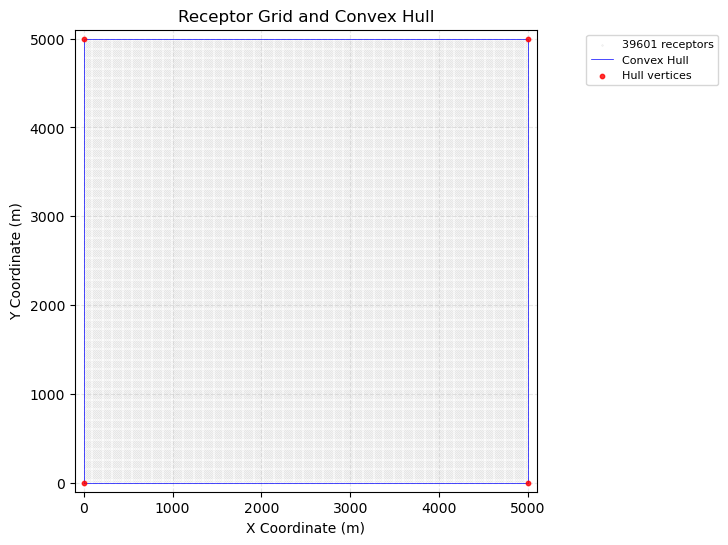

In [43]:
from matplotlib import cm
from scipy.spatial import ConvexHull

# Expecting receptor_df with columns ['receptor_id','x(m)','y(m)']
receptor_points = receptor_df[['x(m)', 'y(m)']].to_numpy()

# Optional grouping by day_index (from previous steps). Otherwise no grouping.
use_groups = 'day_index' in globals() and len(day_index) == len(receptor_points)
if use_groups:
    groups = np.unique(day_index)
    colors = cm.viridis(np.linspace(0, 1, groups.size))
    color_map = {g: c for g, c in zip(groups, colors)}


axis_min = min(x_min, y_min)  # Smallest bound across both axes
axis_max = max(x_max, y_max)  # Largest bound across both axes
pad = 100

plt.figure(figsize=(6, 6))

# Scatter receptors
if use_groups:
    for g in groups:
        mask = (day_index == g)
        plt.scatter(receptor_points[mask, 0], receptor_points[mask, 1],
                    color=color_map[g], alpha=0.1, marker='x', s=1,
                    label=f'Day {int(g)+1}')
else:
    plt.scatter(receptor_points[:, 0], receptor_points[:, 1],
                marker='x', color='gray', s=1, alpha=0.1, label=f'{len(receptor_points)} receptors')
# Convex hull
closed = np.vstack([hull_vertices, hull_vertices[0]])
plt.plot(closed[:, 0], closed[:, 1], color='blue', lw=0.5, label='Convex Hull')

# Hull vertices
plt.scatter(hull_vertices[:, 0], hull_vertices[:, 1],
            color='red', s=10, alpha=0.8, label='Hull vertices', zorder=5)

# Formatting
plt.title('Receptor Grid and Convex Hull')
plt.xlabel('X Coordinate (m)')
plt.ylabel('Y Coordinate (m)')
plt.grid(True, alpha=0.3, linestyle='--')
plt.gca().set_aspect('equal', adjustable='box')

plt.xlim(x_min - pad, x_max + pad)
plt.ylim(y_min - pad, y_max + pad)
# plt.xticks(np.arange(0, 1001, 250))
# plt.yticks(np.arange(0, 1751, 250))
plt.legend(loc='upper center', bbox_to_anchor=(1.25, 1.0), fontsize=8)
plt.show()

### Assign different measurement days to the receptors

In [67]:
weather_df.iloc[[0]]

,Index,Weather_Index,Date,Year,Quarter,Weather_Index,Wind_Speed,Wind_Direction,Temperature,Class
0,1,1,2021-11-03,2021,Q4,1,3.18,50.0,8.8,C


In [113]:
# We can define the number of days here both randomly or fixed
n_days = 1 #random.choice([1, 2, 3, 4, 5, 6, 7])
print(f"Selected n_days: {n_days}")

receptor_day_df_0 = assign_days_same_quarter(
    receptor_df,
    n_days=n_days,
    weather_df=weather_df.iloc[[0]],
    seed=None
)

receptor_day_df_1 = assign_days_same_quarter(
    receptor_df,
    n_days=n_days,
    weather_df=weather_df.iloc[[1]],
    seed=None
)

receptor_day_df_2 = assign_days_same_quarter(
    receptor_df,
    n_days=n_days,
    weather_df=weather_df.iloc[[2]],
    seed=None
)

Selected n_days: 1
Chosen quarter for assignment: Q4
Chosen day_ids for assignment: 1 

Chosen quarter for assignment: Q2
Chosen day_ids for assignment: 2 

Chosen quarter for assignment: Q3
Chosen day_ids for assignment: 3 



In [115]:
receptor_day_df_2

,receptor_id,x(m),y(m),Index
0,1,25.0,25.0,3
1,2,50.0,25.0,3
2,3,75.0,25.0,3
3,4,100.0,25.0,3
4,5,125.0,25.0,3
...,...,...,...,...
39596,39597,4875.0,4975.0,3
39597,39598,4900.0,4975.0,3
39598,39599,4925.0,4975.0,3
39599,39600,4950.0,4975.0,3


### Visualizing receptors per day, and adding emission sources

The function `s_point_in_hull` ensures that the sources created at random positions remain within the boundaries of the landfill. The function defines an internal margin (50 m by default) within which no emitting sources can be placed. 

In [72]:
# Manuel source number
sources = random_source_creator(
    hull_vertices=hull_vertices,
    random_num_sources=False,
    num_sources=5,
    seed=None
)
sources

# sources = np.array([[2.64614321e+02, 4.69008062e+02, 3600000*923_611_111.111]])
sources = np.array([[2500, 2500, emissions_rate_micrograms_per_second]])
sources

array([[ 2500.        ,  2500.        , 37599.79593435]])

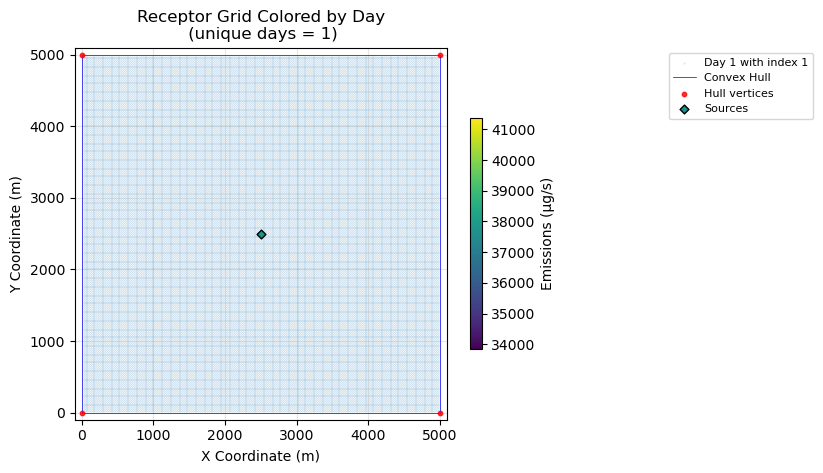

In [ ]:
# Visualization
receptor_points = receptor_day_df_0[['x(m)', 'y(m)']].to_numpy()

# --- Discover distinct days from the DataFrame ---
days = np.array(sorted(receptor_day_df_0['Index'].unique()))
n_days = len(days)
colors = plt.get_cmap('tab10')(np.arange(n_days))
color_map = {d: c for d, c in zip(days, colors)}

# --- Axis range from polygon (symmetric padding) ---
x_min, x_max = hull_vertices[:, 0].min(), hull_vertices[:, 0].max()
y_min, y_max = hull_vertices[:, 1].min(), hull_vertices[:, 1].max()
axis_min = min(x_min, y_min)
axis_max = max(x_max, y_max)
pad = 100

# --- Plot ---
plt.figure(figsize=(6, 6))

# Points by actual day values from receptor_df
for i, d in enumerate(days):
    mask = (receptor_day_df_0['Index'] == d).to_numpy()
    plt.scatter(receptor_points[mask, 0], receptor_points[mask, 1],
                color=color_map[d], alpha=0.1, marker='x', s=1,
                label=f'Day {i+1} with index {d}')

# Convex hull polygon from provided vertices
closed = np.vstack([hull_vertices, hull_vertices[0]])
plt.plot(closed[:, 0], closed[:, 1], color='blue', lw=0.5, label='Convex Hull')
plt.scatter(hull_vertices[:, 0], hull_vertices[:, 1],
            color='red', s=10, alpha=0.8, label='Hull vertices', zorder=5)
# Sources
plt.scatter(sources[:, 0], sources[:, 1], c=sources[:, 2], cmap='viridis', s=20, marker='D', edgecolor='black', label='Sources')

# Formatting
plt.title(f'Receptor Grid Colored by Day\n (unique days = {n_days})')
plt.xlabel('X Coordinate (m)')
plt.ylabel('Y Coordinate (m)')
plt.grid(True, alpha=0.3)
plt.gca().set_aspect('equal', adjustable='box')

plt.xticks(np.arange(0, 5001, 1000))
plt.yticks(np.arange(0, 5001, 1000))
plt.xlim(x_min - pad, x_max + pad)
plt.ylim(y_min - pad, y_max + pad)
plt.legend(loc='upper right', bbox_to_anchor=(2.0, 1.0), fontsize=8)
plt.colorbar(label='Emissions (µg/s)', shrink=0.5) 
#plt.savefig("../img/receptor_grid_by_day.png", dpi=300, bbox_inches='tight')
plt.show()

In [116]:
synthetic_df_0, sources_0 = generate_receptor_concentrations_by_day(
    receptor_df=receptor_day_df_0,
    weather_df=weather_df.iloc[[0]],
    sources=sources,
    wind_speed_col="Wind_Speed",
    wind_dir_col="Wind_Direction",
    stability_col="Class",
    day_col="Index",
    background_ppm=pfas_bg_conc_ppm, # 0.000175 ppm
    return_ppm=True
)

synthetic_df_1, sources_1 = generate_receptor_concentrations_by_day(
    receptor_df=receptor_day_df_1,
    weather_df=weather_df.iloc[[1]],
    sources=sources,
    wind_speed_col="Wind_Speed",
    wind_dir_col="Wind_Direction",
    stability_col="Class",
    day_col="Index",
    background_ppm=pfas_bg_conc_ppm, # 0.000175 ppm
    return_ppm=True
)

synthetic_df_2, sources_2 = generate_receptor_concentrations_by_day(
    receptor_df=receptor_day_df_2,
    weather_df=weather_df.iloc[[2]],
    sources=sources,
    wind_speed_col="Wind_Speed",
    wind_dir_col="Wind_Direction",
    stability_col="Class",
    day_col="Index",
    background_ppm=pfas_bg_conc_ppm, # 0.000175 ppm
    return_ppm=True
)

Wind speed: 3.18, Wind rad: 0.8726646259971648, Stability: C, Wind degree: 50.0, Num receptors: 39601
Wind speed: 2.57, Wind rad: 4.1887902047863905, Stability: B, Wind degree: 240.0, Num receptors: 39601
Wind speed: 3.11, Wind rad: 0.6981317007977318, Stability: B, Wind degree: 40.0, Num receptors: 39601


In [119]:
synthetic_df_1['concentration(ppm)'].describe()

count    39601.000000
mean         0.000019
std          0.000779
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.110759
Name: concentration(ppm), dtype: float64

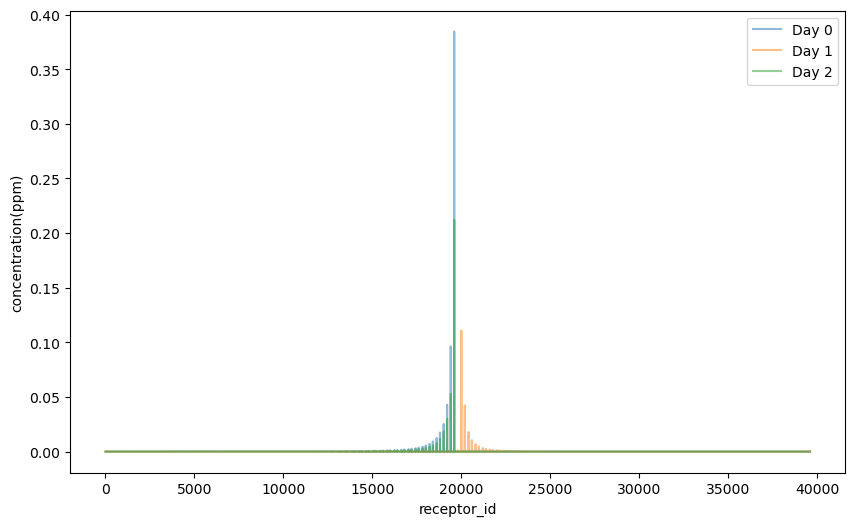

In [122]:
plt.figure(figsize=(10, 6))

for i, df in enumerate([synthetic_df_0, synthetic_df_1, synthetic_df_2]):
    plt.plot(
        df["receptor_id"],
        df["concentration(ppm)"],
        alpha=0.5,
        label=f"Day {i}"
    )

plt.xlabel("receptor_id")
plt.ylabel("concentration(ppm)")
plt.legend()
# plt.yscale("log")

plt.show()

In [79]:
c = synthetic_df['concentration(ppm)'] > 0   # evitar ceros si corresponde
mu = np.mean(c)
sigma = np.std(c)


std1 = (mu - sigma, mu + sigma)
std2 = (mu - 2*sigma, mu + 2*sigma)
std3 = (mu - 3*sigma, mu + 3*sigma)

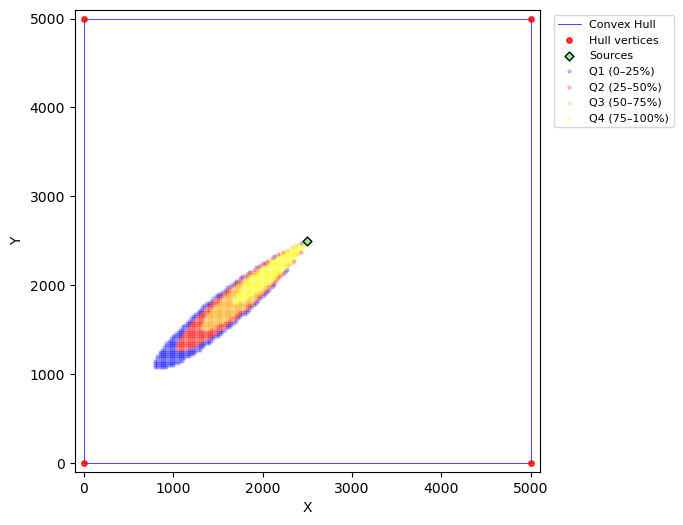

In [82]:
# --- Extract columns ---
x = synthetic_df['x(m)'].to_numpy()
y = synthetic_df['y(m)'].to_numpy()
conc = synthetic_df['concentration(ppm)'].to_numpy()

# --- Mask non-zero concentrations ---
mask_nz = conc > 0
x_nz = x[mask_nz]
y_nz = y[mask_nz]
c_nz = conc[mask_nz]

if c_nz.size == 0:
    print("All concentrations are zero (no non-zero values to compute quartiles).")
    # Option A: stop here
    # raise ValueError("No non-zero concentrations found.")
    # Option B: plot something else or just return
else:
    # --- Quartiles (non-zero only) ---
    q1 = np.percentile(c_nz, 25)
    q2 = np.percentile(c_nz, 50)   # median
    q3 = np.percentile(c_nz, 75)

    # --- Quartile masks ---
    m_q1 = (c_nz <= q1)
    m_q2 = (c_nz > q1) & (c_nz <= q2)
    m_q3 = (c_nz > q2) & (c_nz <= q3)
    m_q4 = (c_nz > q3)

    # --- Plot (only if there are non-zero points) ---
    plt.figure(figsize=(6, 6))

    closed = np.vstack([hull_vertices, hull_vertices[0]])
    plt.plot(closed[:, 0], closed[:, 1], color='blue', lw=0.5, label='Convex Hull')

    plt.scatter(
        hull_vertices[:, 0], hull_vertices[:, 1],
        color='red', s=15, alpha=0.8, label='Hull vertices', zorder=5
    )

    plt.scatter(
        sources[:, 0], sources[:, 1],
        c='lightgreen', s=20, marker='D', edgecolor='black',
        zorder=5, label='Sources'
    )
    s = 5
    alpha = 0.2
    plt.scatter(x_nz[m_q1], y_nz[m_q1], c="blue",   alpha=alpha, s=s, zorder=4, label="Q1 (0–25%)")
    plt.scatter(x_nz[m_q2], y_nz[m_q2], c="red",    alpha=alpha, s=s, zorder=3, label="Q2 (25–50%)")
    plt.scatter(x_nz[m_q3], y_nz[m_q3], c="orange", alpha=alpha, s=s, zorder=2, label="Q3 (50–75%)")
    plt.scatter(x_nz[m_q4], y_nz[m_q4], c="yellow", alpha=alpha, s=s, zorder=1, label="Q4 (75–100%)")
    plt.xticks(np.arange(0, x_lim+1, 1000))
    plt.yticks(np.arange(0, y_lim+1, 1000))
    plt.xlim(x_min - pad, x_max + pad)
    plt.ylim(y_min - pad, y_max + pad)

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=8)
    plt.show()

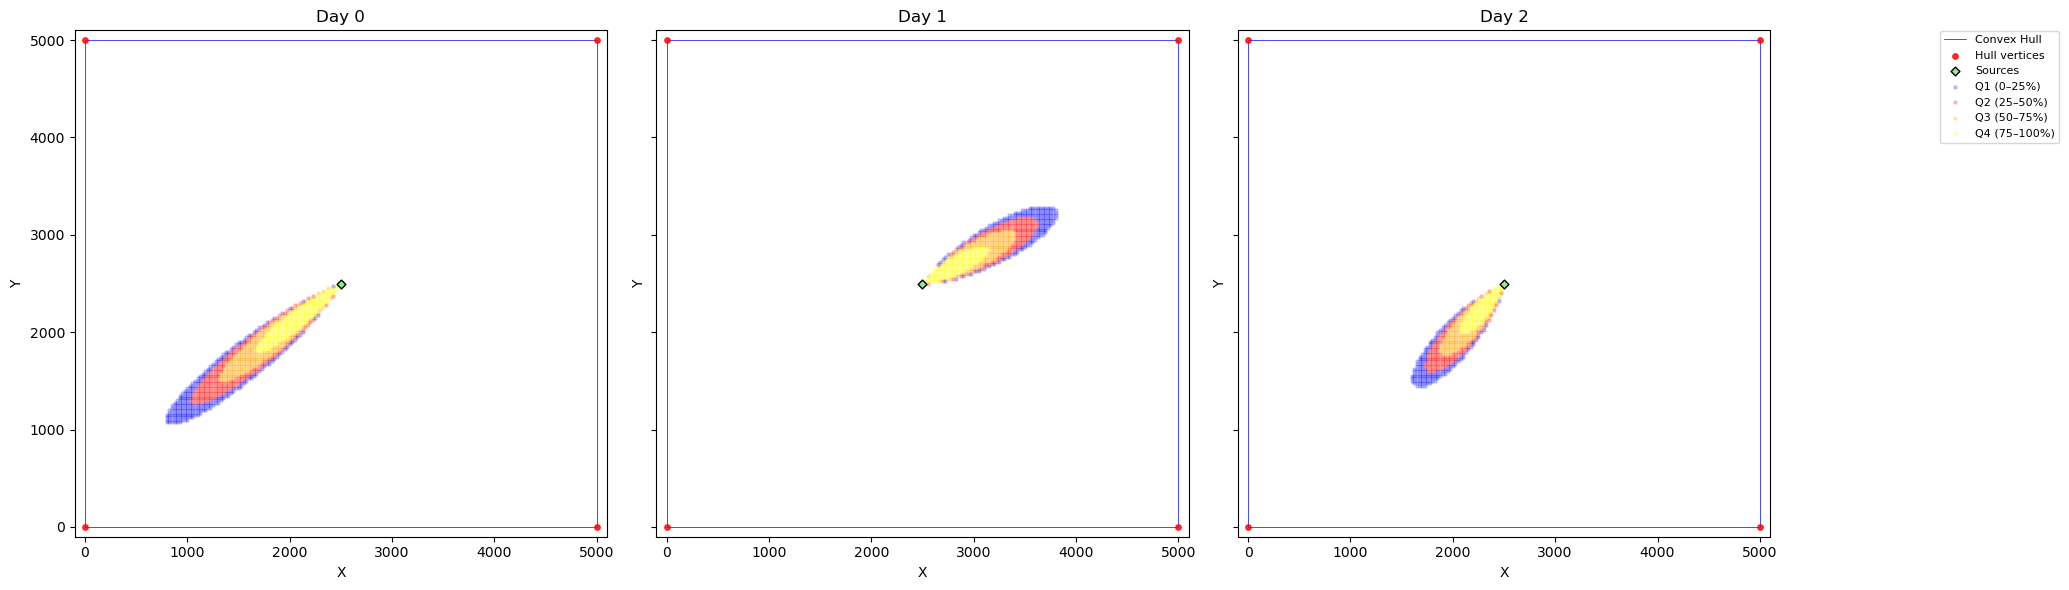

In [124]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
synthetic_list = [synthetic_df_0, synthetic_df_1, synthetic_df_2]
titles = ["Day 0", "Day 1", "Day 2"]

closed = np.vstack([hull_vertices, hull_vertices[0]])

for ax, df, title in zip(axes, synthetic_list, titles):

    # --- Extract columns ---
    x = df['x(m)'].to_numpy()
    y = df['y(m)'].to_numpy()
    conc = df['concentration(ppm)'].to_numpy()

    # --- Mask non-zero concentrations ---
    mask_nz = conc > 0
    x_nz = x[mask_nz]
    y_nz = y[mask_nz]
    c_nz = conc[mask_nz]

    ax.set_title(title)

    if c_nz.size == 0:
        ax.text(0.5, 0.5, "All concentrations = 0",
                ha="center", va="center", transform=ax.transAxes)
        continue

    # --- Quartiles (non-zero only) ---
    q1 = np.percentile(c_nz, 25)
    q2 = np.percentile(c_nz, 50)   # median
    q3 = np.percentile(c_nz, 75)

    # --- Quartile masks ---
    m_q1 = (c_nz <= q1)
    m_q2 = (c_nz > q1) & (c_nz <= q2)
    m_q3 = (c_nz > q2) & (c_nz <= q3)
    m_q4 = (c_nz > q3)

    # --- Base geometry: hull + sources ---
    ax.plot(closed[:, 0], closed[:, 1],
            color='blue', lw=0.5, label='Convex Hull')

    ax.scatter(
        hull_vertices[:, 0], hull_vertices[:, 1],
        color='red', s=15, alpha=0.8,
        label='Hull vertices', zorder=5
    )

    ax.scatter(
        sources[:, 0], sources[:, 1],
        c='lightgreen', s=20, marker='D',
        edgecolor='black', zorder=5,
        label='Sources'
    )

    # --- Receptors by quartile ---
    s = 5
    alpha = 0.2
    ax.scatter(x_nz[m_q1], y_nz[m_q1], c="blue",
               alpha=alpha, s=s, zorder=4, label="Q1 (0–25%)")
    ax.scatter(x_nz[m_q2], y_nz[m_q2], c="red",
               alpha=alpha, s=s, zorder=3, label="Q2 (25–50%)")
    ax.scatter(x_nz[m_q3], y_nz[m_q3], c="orange",
               alpha=alpha, s=s, zorder=2, label="Q3 (50–75%)")
    ax.scatter(x_nz[m_q4], y_nz[m_q4], c="yellow",
               alpha=alpha, s=s, zorder=1, label="Q4 (75–100%)")

    ax.set_xticks(np.arange(0, x_lim + 1, 1000))
    ax.set_yticks(np.arange(0, y_lim + 1, 1000))
    ax.set_xlim(x_min - pad, x_max + pad)
    ax.set_ylim(y_min - pad, y_max + pad)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

# Put a single legend outside (take handles from last axis)
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.15, 0.95), fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
# # --------------------------------------------------------
# # Distances from nerest source to max point in Q4, Q3, Q2
# # --------------------------------------------------------
# def max_point_and_dist(mask, label):
#     idxs = np.where(mask)[0]
#     if idxs.size == 0:
#         print(f"No points in {label}.")
#         return None

#     # 1) Max concentration point within this quartile
#     local_max_idx = np.argmax(c_nz[idxs])
#     global_idx = idxs[local_max_idx]

#     x_max = x_nz[global_idx]
#     y_max = y_nz[global_idx]
#     c_max = c_nz[global_idx]

#     # 2) Source associated to this quartile: nearest to the max–conc point
#     dists_to_sources = np.sqrt(
#         (sources[:, 0] - x_max) ** 2 + (sources[:, 1] - y_max) ** 2
#     )
#     src_idx = np.argmin(dists_to_sources)

#     # If sources is [x, y, Q]
#     sx, sy, _ = sources[src_idx]       # or: sx, sy = sources[src_idx, :2]

#     # 3) Distance from that source to the farthest point in this quartile
#     x_q = x_nz[idxs]
#     y_q = y_nz[idxs]
#     dists_src_to_pts = np.sqrt((x_q - sx) ** 2 + (y_q - sy) ** 2)
#     max_dist = dists_src_to_pts.max()

#     print(
#         f"{label}: max conc={c_max:.3e} at (x={x_max:.2f}, y={y_max:.2f}), "
#         f"assigned source index={src_idx}, farthest point distance={max_dist:.2f} m"
#     )

#     return x_max, y_max, c_max, src_idx, max_dist

# # Q4, Q3, Q2 (from highest to lower quartiles)
# _, _, _, _, d_q4 = max_point_and_dist(m_q4, "Q4 (75–100%)")
# _, _, _, _, d_q3 = max_point_and_dist(m_q3, "Q3 (50–75%)")
# _, _, _, _, d_q2 = max_point_and_dist(m_q2, "Q2 (25–50%)")
# _, _, _, _, d_q1 = max_point_and_dist(m_q1, "Q1 (0–25%)")

In [142]:
# --------------------------------------------------------
# 1. Función genérica: distancia por cuartil para un dataset
# --------------------------------------------------------
def max_point_and_dist(x_nz, y_nz, c_nz, sources, mask, label):
    idxs = np.where(mask)[0]
    if idxs.size == 0:
        print(f"No points in {label}.")
        return None

    # 1) Max concentración dentro del cuartil
    local_max_idx = np.argmax(c_nz[idxs])
    global_idx = idxs[local_max_idx]

    x_max = x_nz[global_idx]
    y_max = y_nz[global_idx]
    c_max = c_nz[global_idx]

    # 2) Fuente asociada: la más cercana al punto de máxima concentración
    dists_to_sources = np.sqrt(
        (sources[:, 0] - x_max) ** 2 + (sources[:, 1] - y_max) ** 2
    )
    src_idx = np.argmin(dists_to_sources)
    sx, sy, _ = sources[src_idx]

    # 3) Distancia desde esa fuente al punto más lejano del cuartil
    x_q = x_nz[idxs]
    y_q = y_nz[idxs]
    dists_src_to_pts = np.sqrt((x_q - sx) ** 2 + (y_q - sy) ** 2)
    max_dist = dists_src_to_pts.max()

    print(
        f"{label}: max conc={c_max:.3e} at (x={x_max:.2f}, y={y_max:.2f}), "
        f"assigned source index={src_idx}, farthest point distance={max_dist:.2f} m"
    )

    return max_dist


def quartile_distances_for_df(synthetic_df, sources):
    """
    Calcula d_q1, d_q2, d_q3, d_q4 para un synthetic_df dado.
    Devuelve un dict con las distancias por cuartil.
    """
    # Extrae columnas y filtra concentraciones > 0
    x = synthetic_df['x(m)'].to_numpy()
    y = synthetic_df['y(m)'].to_numpy()
    conc = synthetic_df['concentration(ppm)'].to_numpy()

    mask_nz = conc > 0
    x_nz = x[mask_nz]
    y_nz = y[mask_nz]
    c_nz = conc[mask_nz]

    if c_nz.size == 0:
        print("All concentrations are zero in this dataset.")
        return {"Q1": None, "Q2": None, "Q3": None, "Q4": None}

    # Quartiles
    q1 = np.percentile(c_nz, 25)
    q2 = np.percentile(c_nz, 50)   # mediana
    q3 = np.percentile(c_nz, 75)

    m_q1 = (c_nz <= q1)
    m_q2 = (c_nz > q1) & (c_nz <= q2)
    m_q3 = (c_nz > q2) & (c_nz <= q3)
    m_q4 = (c_nz > q3)

    # Distancias por cuartil (pueden ser None si no hay puntos)
    d_q4 = max_point_and_dist(x_nz, y_nz, c_nz, sources, m_q4, "Q4 (75–100%)")
    d_q3 = max_point_and_dist(x_nz, y_nz, c_nz, sources, m_q3, "Q3 (50–75%)")
    d_q2 = max_point_and_dist(x_nz, y_nz, c_nz, sources, m_q2, "Q2 (25–50%)")
    d_q1 = max_point_and_dist(x_nz, y_nz, c_nz, sources, m_q1, "Q1 (0–25%)")

    return {"Q1": d_q1, "Q2": d_q2, "Q3": d_q3, "Q4": d_q4}


# --------------------------------------------------------
# 2. Aplicar a las TRES emisiones y promediar
# --------------------------------------------------------
synthetic_list = [synthetic_df_0, synthetic_df_1, synthetic_df_2]

# Acumuladores por cuartil
acc = {"Q1": [], "Q2": [], "Q3": [], "Q4": []}

for i, df_syn in enumerate(synthetic_list):
    print(f"\n=== Synthetic set {i} ===")
    dists = quartile_distances_for_df(df_syn, sources)
    for q in ["Q1", "Q2", "Q3", "Q4"]:
        if dists[q] is not None:
            acc[q].append(dists[q])

# Distancias promedio por cuartil (a partir de las tres emisiones)
d_q1_mean = np.mean(acc["Q1"]) if acc["Q1"] else np.nan
d_q2_mean = np.mean(acc["Q2"]) if acc["Q2"] else np.nan
d_q3_mean = np.mean(acc["Q3"]) if acc["Q3"] else np.nan
d_q4_mean = np.mean(acc["Q4"]) if acc["Q4"] else np.nan

print("\n=== Average distances over 3 synthetic emissions ===")
print(f"Q1 mean distance: {d_q1_mean:.2f} m")
print(f"Q2 mean distance: {d_q2_mean:.2f} m")
print(f"Q3 mean distance: {d_q3_mean:.2f} m")
print(f"Q4 mean distance: {d_q4_mean:.2f} m")


=== Synthetic set 0 ===
Q4 (75–100%): max conc=3.845e-01 at (x=2475.00, y=2475.00), assigned source index=0, farthest point distance=1081.95 m
Q3 (50–75%): max conc=4.589e-04 at (x=2025.00, y=2225.00), assigned source index=0, farthest point distance=1546.16 m
Q2 (25–50%): max conc=1.558e-04 at (x=1325.00, y=1600.00), assigned source index=0, farthest point distance=1901.48 m
Q1 (0–25%): max conc=5.308e-05 at (x=1550.00, y=1500.00), assigned source index=0, farthest point distance=2218.25 m

=== Synthetic set 1 ===
Q4 (75–100%): max conc=1.108e-01 at (x=2550.00, y=2525.00), assigned source index=0, farthest point distance=738.24 m
Q3 (50–75%): max conc=5.086e-04 at (x=2975.00, y=2875.00), assigned source index=0, farthest point distance=1041.93 m
Q2 (25–50%): max conc=1.747e-04 at (x=3250.00, y=3050.00), assigned source index=0, farthest point distance=1286.95 m
Q1 (0–25%): max conc=5.790e-05 at (x=2850.00, y=2875.00), assigned source index=0, farthest point distance=1500.83 m

=== Sy

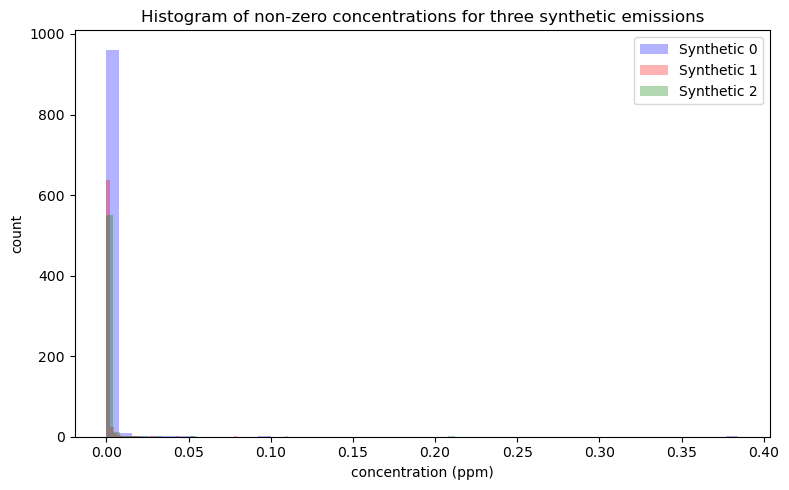

In [153]:
# Histograms of non-zero concentrations for the three synthetic datasets

datasets = [synthetic_df_0, synthetic_df_1, synthetic_df_2]
labels   = ["Synthetic 0", "Synthetic 1", "Synthetic 2"]
colors   = ["blue", "red", "green"]

plt.figure(figsize=(8, 5))

for df, lab, col in zip(datasets, labels, colors):
    # Select non-zero concentrations
    a = df[df["concentration(ppm)"] > 0]["concentration(ppm)"]

    # Skip empty datasets
    if a.empty:
        continue

    # Overlay histograms
    plt.hist(
        a,
        bins=50,
        alpha=0.3,
        color=col,
        label=lab
    )

plt.xlabel("concentration (ppm)")
plt.ylabel("count")
plt.title("Histogram of non-zero concentrations for three synthetic emissions")
plt.legend()
plt.tight_layout()
plt.show()

### Ploting concentratios per day

In [ ]:
# from scipy.interpolate import griddata

# def plot_daily_concentration_panels(
#     final_df,
#     weather_df,
#     hull_vertices,
#     sources,
#     x_min, x_max, y_min, y_max,
#     day_col="Index",
#     wind_dir_col="Wind_Direction"
# ):
#     """
#     Plots one panel per weather day showing:
#     - Convex hull
#     - Receptor grid for the day
#     - Interpolated concentration field
#     - Wind direction arrow
#     - Emission sources

#     Parameters
#     ----------
#     final_df : pd.DataFrame
#         DataFrame with receptor coordinates, concentration(ppm), and day index.
#     weather_df : pd.DataFrame
#         Contains wind direction per day (in degrees).
#     hull_vertices : np.ndarray (n, 2)
#         Convex hull polygon vertices.
#     sources : np.ndarray (n_sources, 3)
#         Emission sources [x, y, Q].
#     x_min, x_max, y_min, y_max : float
#         Bounds for plotting and interpolation.
#     day_col : str
#         Column name indicating day ID (default: "Index").
#     wind_dir_col : str
#         Column name for wind direction in degrees (default: "Wind_Direction").
#     """
#     unique_days = sorted(final_df[day_col].unique())
#     n_days = len(unique_days)

#     # Define layout
#     if n_days <= 4:
#         nrows, ncols = 1, n_days
#     elif n_days <= 6:
#         nrows, ncols = 2, 3
#     else:
#         nrows, ncols = 2, 4

#     fig, axes = plt.subplots(nrows, ncols, figsize=(8 * ncols, 12 * nrows), squeeze=False)
#     axes_flat = axes.flatten()

#     closed_hull = np.vstack([hull_vertices, hull_vertices[0]])

#     for i, day in enumerate(unique_days):
#         ax = axes_flat[i]
#         day_df = final_df[final_df[day_col] == day]
#         receptor_points = day_df[["x(m)", "y(m)"]].to_numpy()
#         concentrations = day_df["concentration(ppm)"].to_numpy()

#         # Interpolation grid
#         grid_res = 200
#         xx, yy = np.meshgrid(
#             np.linspace(x_min, x_max, grid_res),
#             np.linspace(y_min, y_max, grid_res)
#         )

#         grid_conc = griddata(
#             points=receptor_points,
#             values=concentrations,
#             xi=(xx, yy),
#             method="linear",
#             fill_value=np.nan
#         )

#         # Plot convex hull
#         ax.plot(closed_hull[:, 0], closed_hull[:, 1], 'b-', lw=1, label='Convex Hull')

#         # Plot concentration field
#         ax.contourf(xx, yy, grid_conc, levels=50, cmap='jet', alpha=0.5)

#         # Plot receptor points
#         ax.scatter(receptor_points[:, 0], receptor_points[:, 1], alpha=0.1,c='gray', s=1, label='Receptors')

#         # Plot sources
#         ax.scatter(
#             sources[:, 0], sources[:, 1],
#             c=sources[:, 2], cmap='viridis',
#             s=20, marker='d', edgecolor='black',
#             label='Sources'
#         )

#         # Plot wind direction arrow
#         wind_deg = weather_df.loc[weather_df[day_col] == day, wind_dir_col].values[0]
#         wind_rad = np.radians((270 - wind_deg) % 360)  # Meteorological to mathematical

#         arrow_length = 100
#         center_x = x_max * 0.85
#         center_y = y_max * 0.7
#         dx = arrow_length * np.cos(wind_rad)
#         dy = arrow_length * np.sin(wind_rad)

#         ax.arrow(center_x, center_y, dx, dy, width=5, color='green', head_width=30, head_length=30)

#         if center_y >= center_y + dy:
#             ax.text(center_x, center_y + 30, f"{wind_deg:.0f}°", color='green')
#         else:
#             ax.text(center_x, center_y - 80, f"{wind_deg:.0f}°", color='green')

#         # Title and layout
#         stability = weather_df.loc[weather_df[day_col] == day, 'Class'].values[0]
#         ax.set_title(f"Day {day} | Wind {wind_deg}° | Class {stability}")
#         ax.set_xlabel("X (m)")
#         ax.set_ylabel("Y (m)")
#         ax.set_aspect("equal", adjustable="box")
#         ax.set_xlim(x_min - 50, x_max + 50)
#         ax.set_ylim(y_min - 50, y_max + 50)
#         ax.legend(loc='upper right')

#     # Hide unused subplots
#     for j in range(n_days, len(axes_flat)):
#         axes_flat[j].axis("off")
   
#     plt.tight_layout()
#     plt.show()

In [ ]:
# plot_daily_concentration_panels(
#     final_df=synthetic_df,
#     weather_df=weather_df,
#     hull_vertices=hull_vertices,
#     sources=sources,
#     x_min=x_min,
#     x_max=x_max,
#     y_min=y_min,
#     y_max=y_max
# )

In [104]:
# Get concentration at point (500, 500)
px, py = 2500, 2200
point_xy = synthetic_df[(synthetic_df['x(m)'] == px) & (synthetic_df['y(m)'] == py)]
concentration_value = point_xy['concentration(ppm)'].values[0]

print(f"Concentration at point ({px}, {py}): {concentration_value:.3e} ppm")


Concentration at point (2500, 2200): 0.000e+00 ppm


In [108]:
centroid = centroid_w
convex_hull = convex_hull_wake

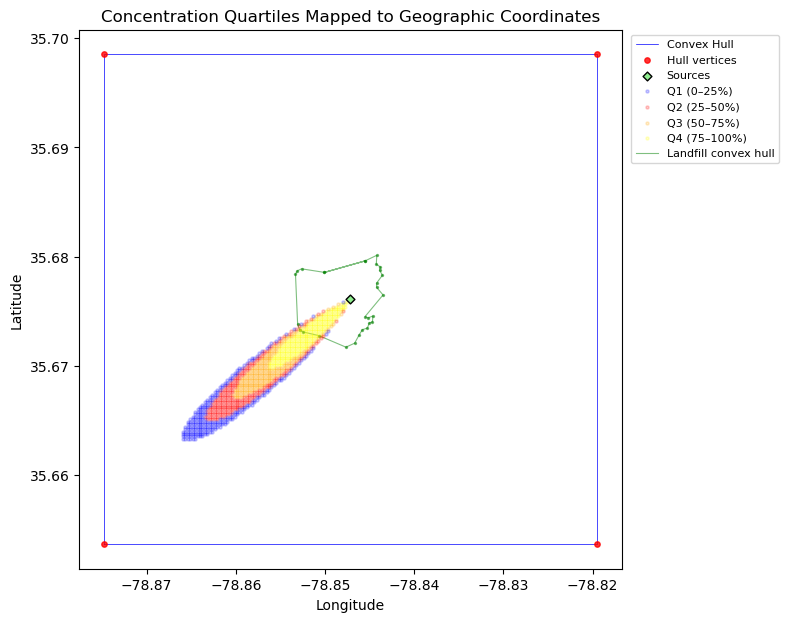

In [ ]:
# ------------------------------------------------------------
# 1. Geographic reference (source center)
# ------------------------------------------------------------
lat0 = centroid[0]
lon0 = centroid[1]
meters_per_deg_lat = 111320
meters_per_deg_lon = 111320 * np.cos(np.deg2rad(lat0))



def xy_to_latlon(x, y, centroid, x0=2500, y0=2500):
    """
    Convert (x, y) meters to geographic coordinates (lat, lon),
    using 'centroid' as reference origin.
    """
    lat0, lon0 = centroid              # centroid = (lat, lon)

    meters_per_deg_lat = 111_320
    meters_per_deg_lon = 111_320 * np.cos(np.deg2rad(lat0))

    dx = x - x0    # east offset in meters
    dy = y - y0    # north offset in meters

    lat = lat0 + dy / meters_per_deg_lat
    lon = lon0 + dx / meters_per_deg_lon
    return lat, lon

# ------------------------------------------------------------
# 2. Extract columns and mask zero concentrations
# ------------------------------------------------------------
x = synthetic_df['x(m)'].to_numpy()
y = synthetic_df['y(m)'].to_numpy()
conc = synthetic_df['concentration(ppm)'].to_numpy()

mask_nz = conc > 0
x_nz = x[mask_nz]
y_nz = y[mask_nz]
c_nz = conc[mask_nz]

# ------------------------------------------------------------
# 3. Quartiles (based on non-zero concentration values)
# ------------------------------------------------------------
q1 = np.percentile(c_nz, 25)
q2 = np.percentile(c_nz, 50)   # median
q3 = np.percentile(c_nz, 75)

m_q1 = (c_nz <= q1)
m_q2 = (c_nz > q1) & (c_nz <= q2)
m_q3 = (c_nz > q2) & (c_nz <= q3)
m_q4 = (c_nz > q3)

# ------------------------------------------------------------
# 4. Convert EVERYTHING to geographic coordinates
# ------------------------------------------------------------

# Non-zero points
lat_nz, lon_nz = xy_to_latlon(x_nz, y_nz, centroid)

# Sources
src_x = sources[:, 0]
src_y = sources[:, 1]
src_lat, src_lon = xy_to_latlon(src_x, src_y, centroid)

# Hull vertices
hv_x = hull_vertices[:, 0]
hv_y = hull_vertices[:, 1]
hv_lat, hv_lon = xy_to_latlon(hv_x, hv_y, centroid)

# Closed hull polygon
closed_hv = np.vstack([hull_vertices, hull_vertices[0]])
closed_lat, closed_lon = xy_to_latlon(closed_hv[:, 0], closed_hv[:, 1], centroid)

# ------------------------------------------------------------
# 4bis. Google Earth convex hull (already in lat/lon)
# ------------------------------------------------------------
ge_hull_lat = convex_hull[:, 0]
ge_hull_lon = convex_hull[:, 1]

# Close polygon
ge_closed_lat = np.r_[ge_hull_lat, ge_hull_lat[0]]
ge_closed_lon = np.r_[ge_hull_lon, ge_hull_lon[0]]



# ------------------------------------------------------------
# 5. Plot (lat/lon)
# ------------------------------------------------------------
plt.figure(figsize=(7, 7))

# Hull polygon
plt.plot(closed_lon, closed_lat, color='blue', lw=0.5, label='Convex Hull')

# Hull vertices
plt.scatter(hv_lon, hv_lat, color='red', s=15, alpha=0.8,
            label='Hull vertices', zorder=5)

# Sources (now georeferenced)
plt.scatter(src_lon, src_lat, c='lightgreen', s=20, marker='D',
            edgecolor='black', zorder=5, label='Sources')

# Quartile-colored concentrations (now georeferenced)
s = 5
alpha = 0.2
plt.scatter(lon_nz[m_q1], lat_nz[m_q1],
            c="blue", alpha=alpha, s=s, zorder=5, label="Q1 (0–25%)")

plt.scatter(lon_nz[m_q2], lat_nz[m_q2],
            c="red", alpha=alpha, s=s, zorder=4, label="Q2 (25–50%)")

plt.scatter(lon_nz[m_q3], lat_nz[m_q3],
            c="orange", alpha=alpha, s=s, zorder=3, label="Q3 (50–75%)")

plt.scatter(lon_nz[m_q4], lat_nz[m_q4],
            c="yellow", alpha=alpha, s=s , zorder=2, label="Q4 (75–100%)")

# Google Earth hull (reference polygon)
plt.plot(ge_closed_lon, ge_closed_lat,
         color='green', lw=0.8, alpha=0.5,ls='-', zorder=1, label='Landfill convex hull')

plt.scatter(ge_hull_lon, ge_hull_lat,
            color='green', s=2, alpha=0.5, zorder=1)

# Labels
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Concentration Quartiles Mapped to Geographic Coordinates")

# Legend
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=8)

plt.show()

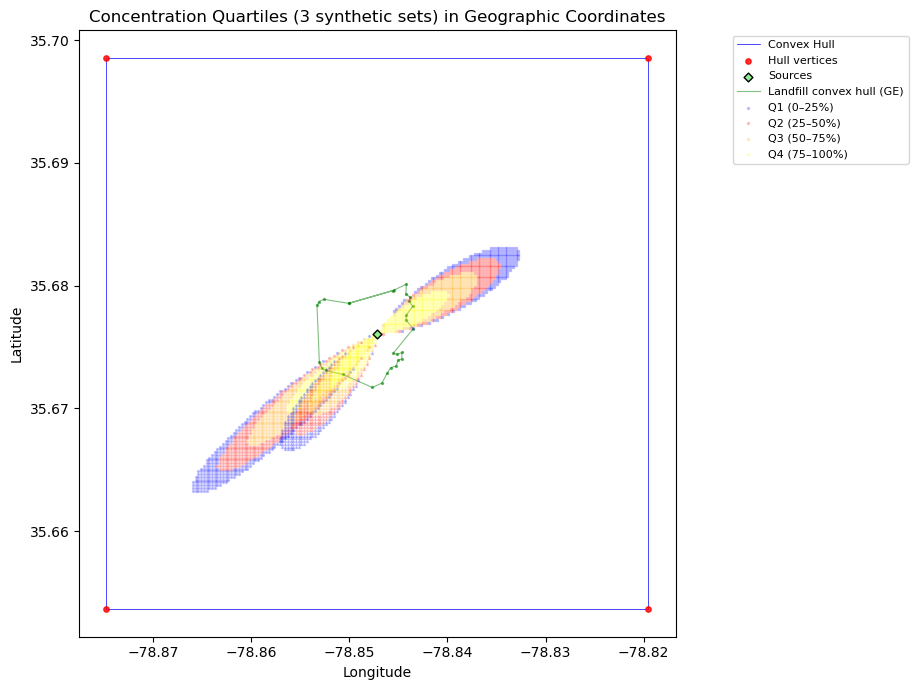

In [ ]:
# ------------------------------------------------------------
# 1. Geographic reference (source center)
# ------------------------------------------------------------
lat0 = centroid[0]
lon0 = centroid[1]
meters_per_deg_lat = 111320
meters_per_deg_lon = 111320 * np.cos(np.deg2rad(lat0))


def xy_to_latlon(x, y, centroid, x0=2500, y0=2500):
    """
    Convert (x, y) meters to geographic coordinates (lat, lon),
    using 'centroid' as reference origin.
    """
    lat0, lon0 = centroid              # centroid = (lat, lon)

    meters_per_deg_lat = 111_320
    meters_per_deg_lon = 111_320 * np.cos(np.deg2rad(lat0))

    dx = x - x0    # east offset in meters
    dy = y - y0    # north offset in meters

    lat = lat0 + dy / meters_per_deg_lat
    lon = lon0 + dx / meters_per_deg_lon
    return lat, lon


# ------------------------------------------------------------
# 2. Precompute geometry common to all sets
# ------------------------------------------------------------
# Sources
src_x = sources[:, 0]
src_y = sources[:, 1]
src_lat, src_lon = xy_to_latlon(src_x, src_y, centroid)

# Hull vertices
hv_x = hull_vertices[:, 0]
hv_y = hull_vertices[:, 1]
hv_lat, hv_lon = xy_to_latlon(hv_x, hv_y, centroid)

# Closed hull polygon
closed_hv = np.vstack([hull_vertices, hull_vertices[0]])
closed_lat, closed_lon = xy_to_latlon(closed_hv[:, 0], closed_hv[:, 1], centroid)

# Google Earth convex hull (already in lat/lon)
ge_hull_lat = convex_hull[:, 0]
ge_hull_lon = convex_hull[:, 1]
ge_closed_lat = np.r_[ge_hull_lat, ge_hull_lat[0]]
ge_closed_lon = np.r_[ge_hull_lon, ge_hull_lon[0]]


# ------------------------------------------------------------
# 3. Single plot for the three synthetic datasets
# ------------------------------------------------------------
synthetic_list = [synthetic_df_0, synthetic_df_1, synthetic_df_2]
labels_sets = ["Set 0", "Set 1", "Set 2"]

plt.figure(figsize=(10, 7))

# Base geometry (only once)
plt.plot(closed_lon, closed_lat, color='blue', lw=0.5, label='Convex Hull')
plt.scatter(hv_lon, hv_lat, color='red', s=15, alpha=0.8,
            label='Hull vertices', zorder=5)
plt.scatter(src_lon, src_lat, c='lightgreen', s=20, marker='D',
            edgecolor='black', zorder=5, label='Sources')
plt.plot(ge_closed_lon, ge_closed_lat,
         color='green', lw=0.8, alpha=0.5, ls='-',
         zorder=1, label='Landfill convex hull (GE)')
plt.scatter(ge_hull_lon, ge_hull_lat,
            color='green', s=2, alpha=0.5, zorder=1)

# Colors per quartile, markers per dataset
colors_q = ["blue", "red", "orange", "yellow"]
markers  = ["o", "s", "^"]   # one marker per synthetic set

s = 2
alpha = 0.2

label = True
for df, set_label, marker in zip(synthetic_list, labels_sets, markers):
    # Extract and mask
    x = df['x(m)'].to_numpy()
    y = df['y(m)'].to_numpy()
    conc = df['concentration(ppm)'].to_numpy()

    mask_nz = conc > 0
    x_nz = x[mask_nz]
    y_nz = y[mask_nz]
    c_nz = conc[mask_nz]

    if c_nz.size == 0:
        continue

    # Quartiles
    q1 = np.percentile(c_nz, 25)
    q2 = np.percentile(c_nz, 50)
    q3 = np.percentile(c_nz, 75)

    m_q1 = (c_nz <= q1)
    m_q2 = (c_nz > q1) & (c_nz <= q2)
    m_q3 = (c_nz > q2) & (c_nz <= q3)
    m_q4 = (c_nz > q3)

    # Convert to lat/lon
    lat_nz, lon_nz = xy_to_latlon(x_nz, y_nz, centroid)

    # Plot quartiles for this dataset (different marker for each set)
    for m_q, color, q_label in zip(
        [m_q1, m_q2, m_q3, m_q4],
        colors_q,
        ["Q1 (0–25%)", "Q2 (25–50%)", "Q3 (50–75%)", "Q4 (75–100%)"]
    ): 
        if label:
            plt.scatter(
                lon_nz[m_q], lat_nz[m_q],
                c=color, alpha=alpha, s=s, marker=marker, zorder=2,
                label=f"{q_label}"
            )
            
        else:
            plt.scatter(
                lon_nz[m_q], lat_nz[m_q],
                c=color, alpha=alpha, s=s, marker=marker, zorder=2,
                label=None 
            )
    label = False

# Labels and legend
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Concentration Quartiles (3 days) - L26")
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.0), fontsize=8)
ax.set_aspect("equal", adjustable="box")

plt.tight_layout()
plt.show()

In [ ]:
# df = synthetic_df.copy()

# # Convertir todas las coordenadas x,y a lat/lon usando el centroid
# lat_arr, lon_arr = xy_to_latlon(
#     df["x(m)"].to_numpy(),
#     df["y(m)"].to_numpy(),
#     centroid=centroid_w,   # (lat0, lon0)
#     x0=2500,
#     y0=2500
# )

# df["lat"] = lat_arr
# df["lon"] = lon_arr

# df

In [ ]:
# # Copy the existing DataFrame
# df = synthetic_df.copy()

# # Known center geographic coordinates
# lat0 = centroid[0]
# lon0 = centroid[1]

# # Conversion factors from meters to degrees
# meters_per_deg_lat = 111320
# meters_per_deg_lon = 111320 * np.cos(np.deg2rad(lat0))

# # Compute offsets in meters relative to the grid center (500, 500)
# dx = df["x(m)"] - 2500   # positive = east
# dy = df["y(m)"] - 2500   # positive = north

# # Convert meter offsets to geographic coordinates
# df["lat"] = lat0 + (dy / meters_per_deg_lat)
# df["lon"] = lon0 + (dx / meters_per_deg_lon)

# df

In [ ]:
# import folium

# # ------------------------------------------------------------
# # Create map centered at the source location
# # ------------------------------------------------------------
# origin_lat, origin_lon = centroid_w


# map_wake = folium.Map(location=[origin_lat, origin_lon], zoom_start=15)


# # ------------------------------------------------------------
# # Add points by quartile (folium version of the matplotlib plot)
# # ------------------------------------------------------------

# # Q1 (blue)
# for lat, lon in zip(lat_nz[m_q1], lon_nz[m_q1]):
#     folium.CircleMarker(
#         location=[lat, lon],
#         radius=1,
#         color='blue',
#         fill=True,
#         fill_color='blue',
#         fill_opacity=0.2
#     ).add_to(map_wake)

# # Q2 (red)
# for lat, lon in zip(lat_nz[m_q2], lon_nz[m_q2]):
#     folium.CircleMarker(
#         location=[lat, lon],
#         radius=1,
#         color='red',
#         fill=True,
#         fill_color='red',
#         fill_opacity=0.3
#     ).add_to(map_wake)

# # Q3 (orange)
# for lat, lon in zip(lat_nz[m_q3], lon_nz[m_q3]):
#     folium.CircleMarker(
#         location=[lat, lon],
#         radius=1,
#         color='orange',
#         fill=True,
#         fill_color='orange',
#         fill_opacity=0.3
#     ).add_to(map_wake)

# # Q4 (yellow)
# for lat, lon in zip(lat_nz[m_q4], lon_nz[m_q4]):
#     folium.CircleMarker(
#         location=[lat, lon],
#         radius=1,
#         color='yellow',
#         fill=True,
#         fill_color='yellow',
#         fill_opacity=0.4
#     ).add_to(map_wake)

# # ------------------------------------------------------------
# # Add sources (converted to lat/lon)
# # ------------------------------------------------------------
# for slat, slon in zip(src_lat, src_lon):
#     folium.Marker(
#         location=[slat, slon],
#         icon=folium.Icon(color="green", icon="info-sign")
#     ).add_to(map_wake)

# # ------------------------------------------------------------
# # Display map
# # ------------------------------------------------------------
# map_wake.save("../img/color_map.html")

In [256]:
# Print quartile ranges
print("Quartile Ranges (non-zero concentrations only):")
print(f"Q1 (0-25%):   {0:.6e} to {q1:.6e} ppm")
print(f"Q2 (25-50%):  {q1:.6e} to {q2:.6e} ppm")
print(f"Q3 (50-75%):  {q2:.6e} to {q3:.6e} ppm")
print(f"Q4 (75-100%): {q3:.6e} to {c_nz.max():.6e} ppm")

Quartile Ranges (non-zero concentrations only):
Q1 (0-25%):   0.000000e+00 to 5.199470e-05 ppm
Q2 (25-50%):  5.199470e-05 to 1.549958e-04 ppm
Q3 (50-75%):  1.549958e-04 to 4.719587e-04 ppm
Q4 (75-100%): 4.719587e-04 to 5.062655e-02 ppm


In [ ]:
# ------------------------------------------------------------
# Landmarks LF 26
# ------------------------------------------------------------
shopping = np.array([35.66666982444289, -78.84621817057246])
vet_hostipal = np.array([35.66460787088358, -78.84825655734113])
target = np.array([35.6615716429336, -78.85204814633124])
hardware_store = np.array([35.66018861561622, -78.83721401892609])
pharmacy = np.array([35.65610271518265, -78.83520942949808])
restaurant = np.array([35.659085489863074, -78.86747163110155])
school1 = np.array([35.6593501476475, -78.83615919965423])
school2 = np.array([35.677851718685694, -78.83425118888651])

school3 = np.array([35.675537057310905, -78.83281063266132])
school4 = np.array([35.66233876540289, -78.85705059177832])
school5 = np.array([35.66290823855504, -78.86562909281928])

In [ ]:
# attr = (
#     '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> '
#     'contributors, &copy; <a href="https://cartodb.com/attributions">CartoDB</a>'
# )
# tiles = "https://{s}.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}.png"

# #    tiles="CartoDB positron" if you need street and places identification

# # Wake county map
# origin_lat = centroid[0]
# origin_lon = centroid[1]

# map_wake = folium.Map(
#     location=[origin_lat, origin_lon], 
#     attr=attr, 
#     zoom_start=15, 
#     tiles=tiles)

# # ------------------------------------------------------------
# # Add circles with radii based on quartile distances
# # ------------------------------------------------------------
# folium.Circle(
#     location=[origin_lat, origin_lon],
#     radius=d_q1,                     # 1st quartile distance
#     color='red',
#     popup="Q1 radius",
#     fill=False,
#     weight=2,
#     opacity=0.6
# ).add_to(map_wake)

# folium.Circle(
#     location=[origin_lat, origin_lon],
#     radius=d_q2,                     # 2nd quartile distance
#     color='red',
#     popup="Q2 radius",
#     fill=False,
#     weight=2,
#     opacity=0.6
# ).add_to(map_wake)

# folium.Circle(
#     location=[origin_lat, origin_lon],
#     radius=d_q3,                     # 3rd quartile distance
#     color='red',
#     popup="Q3 radius",
#     fill=False,
#     weight=2,
#     opacity=0.6
# ).add_to(map_wake)

# folium.Circle(
#     location=[origin_lat, origin_lon],
#     radius=d_q4,                     # 4th quartile distance
#     color='red',
#     popup="Q4 radius",
#     fill=False,
#     weight=2,
#     opacity=0.6
# ).add_to(map_wake)

# radius = 5
# alpha = 0.5

# # Q1 (blue)
# for lat, lon in zip(lat_nz[m_q1], lon_nz[m_q1]):
#     folium.CircleMarker(
#         location=[lat, lon],
#         radius=radius,
#         fill=True,
#         fill_color='blue',
#         fill_opacity=0.2,
#         stroke=False
#     ).add_to(map_wake)

# # Q2 (red)
# for lat, lon in zip(lat_nz[m_q2], lon_nz[m_q2]):
#     folium.CircleMarker(
#         location=[lat, lon],
#         radius=radius,
#         fill=True,
#         fill_color='red',
#         fill_opacity=alpha,
#         stroke=False
#     ).add_to(map_wake)

# # Q3 (orange)
# for lat, lon in zip(lat_nz[m_q3], lon_nz[m_q3]):
#     folium.CircleMarker(
#         location=[lat, lon],
#         radius=radius,
#         fill=True,
#         fill_color='orange',
#         fill_opacity=alpha,
#         stroke=False
#     ).add_to(map_wake)

# # Q4 (yellow)
# for lat, lon in zip(lat_nz[m_q4], lon_nz[m_q4]):
#     folium.CircleMarker(
#         location=[lat, lon],
#         radius=radius,
#         fill=True,
#         fill_color='yellow',
#         fill_opacity=alpha+0.2,
#         stroke=False
#     ).add_to(map_wake)

# # ------------------------------------------------------------
# # Add sources (converted to lat/lon)
# # ------------------------------------------------------------
# for slat, slon in zip(src_lat, src_lon):
#     folium.Marker(
#         location=[slat, slon],
#         icon=folium.Icon(color="green", icon="info-sign")
#     ).add_to(map_wake)

# # ------------------------------------------------------------
# # Add convex hull (Google Earth polygon)
# # convex_hull: array of shape (N, 2) -> [lat, lon]
# # ------------------------------------------------------------
# hull_coords = convex_hull.tolist()  # [[lat, lon], ...]

# folium.Polygon(
#     locations=hull_coords,
#     color='green',
#     weight=2,
#     fill=False,
#     opacity=0.8
# ).add_to(map_wake)

# # ------------------------------------------------------------
# # Add landmarks
# # ------------------------------------------------------------
# landmarks = {
#     "Shopping center":      shopping,
#     "Vet hospital":         vet_hostipal,
#     "Supermarket":          target,
#     "Hardware store":       hardware_store,
#     "Pharmacy":             pharmacy,
#     "Restaurant":           restaurant,
#     "School 1":             school1,
#     "School 2":             school2,
#     "School 3":             school3,
#     "School 4":             school4,
#     "School 5":             school5,
# }

# for name, coord in landmarks.items():
#     folium.Marker(
#         location=[coord[0], coord[1]],
#         popup=name,
#         icon=folium.Icon(color="blue", icon="info-sign")
#     ).add_to(map_wake)

# # Show the map
# map_wake.save("../img/clean_map.html")

In [ ]:
attr = (
    '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> '
    'contributors, &copy; <a href="https://cartodb.com/attributions">CartoDB</a>'
)
tiles = "https://{s}.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}.png"

# Wake county map
origin_lat = centroid[0]
origin_lon = centroid[1]

map_wake = folium.Map(
    location=[origin_lat, origin_lon],
    attr=attr,
    zoom_start=15,
    tiles=tiles
)

# ------------------------------------------------------------
# 1. Quartile distance circles (common)
# ------------------------------------------------------------
folium.Circle(
    location=[origin_lat, origin_lon],
    radius=d_q1_mean,                     # 1st quartile distance
    color='blue',
    popup="Q1 radius",
    fill=False,
    weight=5,
    opacity=0.2
).add_to(map_wake)

folium.Circle(
    location=[origin_lat, origin_lon],
    radius=d_q2_mean,                     # 2nd quartile distance
    color='red',
    popup="Q2 radius",
    fill=False,
    weight=5,
    opacity=0.2
).add_to(map_wake)

folium.Circle(
    location=[origin_lat, origin_lon],
    radius=d_q3_mean,                     # 3rd quartile distance
    color='orange',
    popup="Q3 radius",
    fill=False,
    weight=5,
    opacity=0.2
).add_to(map_wake)

folium.Circle(
    location=[origin_lat, origin_lon],
    radius=d_q4_mean,                     # 4th quartile distance
    color='yellow',
    popup="Q4 radius",
    fill=False,
    weight=5,
    opacity=0.2
).add_to(map_wake)

radius = 3

# ------------------------------------------------------------
# 2. Three synthetic datasets, all in the same map
# ------------------------------------------------------------
synthetic_list = [synthetic_df_0, synthetic_df_1, synthetic_df_2]

for df in synthetic_list:
    # Extrae columnas y filtra concentraciones > 0
    x = df['x(m)'].to_numpy()
    y = df['y(m)'].to_numpy()
    conc = df['concentration(ppm)'].to_numpy()

    mask_nz = conc > 0
    x_nz = x[mask_nz]
    y_nz = y[mask_nz]
    c_nz = conc[mask_nz]

    if c_nz.size == 0:
        continue

    # Quartiles por dataset
    q1 = np.percentile(c_nz, 25)
    q2 = np.percentile(c_nz, 50)
    q3 = np.percentile(c_nz, 75)

    m_q1 = (c_nz <= q1)
    m_q2 = (c_nz > q1) & (c_nz <= q2)
    m_q3 = (c_nz > q2) & (c_nz <= q3)
    m_q4 = (c_nz > q3)

    # Conversión a lat/lon (usa tu función existente xy_to_latlon)
    lat_nz, lon_nz = xy_to_latlon(x_nz, y_nz, centroid)

    alpha = 0.4

    # Q1 (blue)
    for lat, lon in zip(lat_nz[m_q1], lon_nz[m_q1]):
        folium.CircleMarker(
            location=[lat, lon],
            radius=radius,
            fill=True,
            fill_color='blue',
            fill_opacity=0.2,
            stroke=False
        ).add_to(map_wake)

    # Q2 (red)
    for lat, lon in zip(lat_nz[m_q2], lon_nz[m_q2]):
        folium.CircleMarker(
            location=[lat, lon],
            radius=radius,
            fill=True,
            fill_color='red',
            fill_opacity=alpha,
            stroke=False
        ).add_to(map_wake)

    # Q3 (orange)
    for lat, lon in zip(lat_nz[m_q3], lon_nz[m_q3]):
        folium.CircleMarker(
            location=[lat, lon],
            radius=radius,
            fill=True,
            fill_color='orange',
            fill_opacity=alpha,
            stroke=False
        ).add_to(map_wake)

    # Q4 (yellow)
    for lat, lon in zip(lat_nz[m_q4], lon_nz[m_q4]):
        folium.CircleMarker(
            location=[lat, lon],
            radius=radius,
            fill=True,
            fill_color='yellow',
            fill_opacity=alpha + 0.2,
            stroke=False
        ).add_to(map_wake)

# ------------------------------------------------------------
# 3. Sources (ya convertidos a lat/lon previamente)
# ------------------------------------------------------------
for slat, slon in zip(src_lat, src_lon):
    folium.Marker(
        location=[slat, slon],
        icon=folium.Icon(color="green", icon="info-sign")
    ).add_to(map_wake)

# ------------------------------------------------------------
# 4. Convex hull (Google Earth polygon)
#    convex_hull: array (N, 2) -> [lat, lon]
# ------------------------------------------------------------
hull_coords = convex_hull.tolist()  # [[lat, lon], ...]

folium.Polygon(
    locations=hull_coords,
    color='green',
    weight=2,
    fill=False,
    opacity=0.8
).add_to(map_wake)

# ------------------------------------------------------------
# 5. Landmarks
# ------------------------------------------------------------
landmarks = {
    "Shopping center":      shopping,
    "Vet hospital":         vet_hostipal,
    "Supermarket":          target,
    "Hardware store":       hardware_store,
    "Pharmacy":             pharmacy,
    "Restaurant":           restaurant,
    "School 1":             school1,
    "School 2":             school2,
    "School 3":             school3,
    "School 4":             school4,
    "School 5":             school5,
}

for name, coord in landmarks.items():
    folium.Marker(
        location=[coord[0], coord[1]],
        popup=name,
        icon=folium.Icon(color="blue", icon="info-sign")
    ).add_to(map_wake)

# Save map
map_wake.save("../img/clean_map.html")

## Hanover Landfill